In [1]:
# ############################################################################
#
#   Julia Implementation of GPR, TPRK and TPRD
#   (with selectable hyperparameter optimization)
#
# ############################################################################

using Optim
using LinearAlgebra
using SpecialFunctions
using Distributions
using Plots
using Distances

# --- カーネル関数 (共通) ---
struct SquaredExponentialKernel end

function kernel_matrix(::SquaredExponentialKernel, X::AbstractMatrix, params_θ::Vector{Float64})
    log_l, log_σ_n = params_θ
    l = exp(log_l)
    σ_n = exp(log_σ_n)
    sq_dist = pairwise(SqEuclidean(), X, dims=2)
    K_se = exp.(-0.5 * sq_dist / l^2)
    Σ = K_se + Diagonal(fill(σ_n^2 + 1e-6, size(X, 2)))
    return Σ
end

function kernel_matrix_grads(::SquaredExponentialKernel, X::AbstractMatrix, Σ::AbstractMatrix, params_θ::Vector{Float64})
    log_l, log_σ_n = params_θ
    l = exp(log_l)
    σ_n = exp(log_σ_n)
    n = size(X, 2)
    K_se = Σ - Diagonal(fill(σ_n^2 + 1e-6, n))
    sq_dist = pairwise(SqEuclidean(), X, dims=2)
    ∂Σ_∂log_l = K_se .* sq_dist / l^2
    ∂Σ_∂log_σ_n = Diagonal(fill(2 * σ_n^2, n))
    return [∂Σ_∂log_l, ∂Σ_∂log_σ_n]
end

# --- GPR / TP 構造体 ---
abstract type AbstractGPModel end

mutable struct GaussianProcess <: AbstractGPModel
    X::Matrix{Float64}
    y::Vector{Float64}
    kernel::SquaredExponentialKernel
    params_θ::Vector{Float64}

    function GaussianProcess(X, y; kernel=SquaredExponentialKernel(), init_params_θ=[0.0, 0.0])
        new(X, y, kernel, init_params_θ)
    end
end

mutable struct StudentTProcess <: AbstractGPModel
    X::Matrix{Float64}
    y::Vector{Float64}
    kernel::SquaredExponentialKernel
    model_type::Symbol
    params_θ::Vector{Float64}
    log_ν_minus_2::Float64

    function StudentTProcess(X, y, model_type; kernel=SquaredExponentialKernel(), init_params_θ=[0.0, 0.0], init_ν=5.0)
        @assert model_type in [:TPRK, :TPRD] "model_typeは :TPRK または :TPRD である必要があります。"
        @assert init_ν > 2 "νは2より大きくなければなりません。"
        new(X, y, kernel, model_type, init_params_θ, log(init_ν - 2))
    end
end

function get_ν(stp::StudentTProcess)
    return exp(stp.log_ν_minus_2) + 2
end

# --- モデルのインスタンスを生成するヘルパー関数 ---
# パラメータベクトルからモデルを生成
function build_model(model::GaussianProcess, p_full::Vector)
    return GaussianProcess(model.X, model.y; kernel=model.kernel, init_params_θ=p_full)
end
function build_model(model::StudentTProcess, p_full::Vector)
    return StudentTProcess(model.X, model.y, model.model_type; kernel=model.kernel, init_params_θ=p_full[1:2], init_ν=exp(p_full[3])+2)
end

# --- 主要な関数 (尤度、勾配、予測) ---

# GPR用
function log_marginal_likelihood(gp::GaussianProcess)
    X, y = gp.X, gp.y
    n = length(y)
    Σ = kernel_matrix(gp.kernel, X, gp.params_θ)
    C = cholesky(Σ)
    α = C \ y
    lml = -0.5 * dot(y, α) - 0.5 * logdet(C) - n/2 * log(2π)
    return lml
end

function gradient_log_marginal_likelihood(gp::GaussianProcess)
    X, y = gp.X, gp.y
    Σ = kernel_matrix(gp.kernel, X, gp.params_θ)
    C = cholesky(Σ)
    Σ⁻¹ = inv(C)
    α = Σ⁻¹ * y
    ∂Σ_∂θ_list = kernel_matrix_grads(gp.kernel, X, Σ, gp.params_θ)
    grad_params_θ = zeros(length(gp.params_θ))
    common_term = (α * α') - Σ⁻¹
    for i in 1:length(gp.params_θ)
        grad_params_θ[i] = 0.5 * tr(common_term * ∂Σ_∂θ_list[i])
    end
    return grad_params_θ
end

function predict(gp::GaussianProcess, X_new::AbstractMatrix)
    X, y = gp.X, gp.y
    Σ₁₁ = kernel_matrix(gp.kernel, X, gp.params_θ)
    k_params = [gp.params_θ[1], log(1e-9)]
    K₂₁ = kernel_matrix(gp.kernel, gp.X, X_new, k_params)'
    K₂₂_diag = diag(kernel_matrix(gp.kernel, X_new, k_params))
    Σ₁₁⁻¹y = Σ₁₁ \ y
    μ_pred = K₂₁ * Σ₁₁⁻¹y
    K̃₂₂_diag = K₂₂_diag - diag(K₂₁ * (Σ₁₁ \ K₂₁'))
    σ_pred = sqrt.(abs.(K̃₂₂_diag))
    return μ_pred, σ_pred
end

# TP用
function log_marginal_likelihood(stp::StudentTProcess)
    X, y, model_type = stp.X, stp.y, stp.model_type
    n = length(y)
    ν = get_ν(stp)
    Σ = kernel_matrix(stp.kernel, X, stp.params_θ)
    C = cholesky(Σ)
    α = C \ y
    β = dot(y, α)
    log_det_Σ = logdet(C)
    if model_type == :TPRK
        lml = -n/2 * log((ν - 2) * π) - 0.5 * log_det_Σ + (loggamma((ν + n) / 2) - loggamma(ν / 2)) - ((ν + n) / 2) * log(1 + β / (ν - 2))
    else # :TPRD
        lml = -n/2 * log(ν * π) - 0.5 * log_det_Σ + (loggamma((ν + n) / 2) - loggamma(ν / 2)) - ((ν + n) / 2) * log(1 + β / ν)
    end
    return lml
end

function gradient_log_marginal_likelihood(stp::StudentTProcess)
    X, y, model_type = stp.X, stp.y, stp.model_type
    n = length(y)
    ν = get_ν(stp)
    Σ = kernel_matrix(stp.kernel, X, stp.params_θ)
    C = cholesky(Σ)
    Σ⁻¹ = inv(C)
    α = Σ⁻¹ * y
    β = dot(y, α)
    ∂Σ_∂θ_list = kernel_matrix_grads(stp.kernel, X, Σ, stp.params_θ)
    grad_params_θ = zeros(length(stp.params_θ))
    if model_type == :TPRK
        common_term = ((ν + n) / (ν - 2 + β)) * (α * α') - Σ⁻¹
    else # :TPRD
        common_term = ((ν + n) / (ν + β)) * (α * α') - Σ⁻¹
    end
    for i in 1:length(stp.params_θ)
        grad_params_θ[i] = 0.5 * tr(common_term * ∂Σ_∂θ_list[i])
    end
    if model_type == :TPRK
        ∂lml_∂ν = -n / (2 * (ν - 2)) + 0.5 * (digamma((ν + n) / 2) - digamma(ν / 2)) - 0.5 * log(1 + β / (ν - 2)) + ((ν + n) * β) / (2 * (ν - 2)^2 + 2 * β * (ν - 2))
    else # :TPRD
        ∂lml_∂ν = -n / (2 * ν) + 0.5 * (digamma((ν + n) / 2) - digamma(ν / 2)) - 0.5 * log(1 + β / ν) + ((ν + n) * β) / (2 * ν^2 + 2 * β * ν)
    end
    grad_ν = ∂lml_∂ν * (ν - 2)
    return [grad_params_θ; grad_ν]
end

function predict(stp::StudentTProcess, X_new::AbstractMatrix)
    X, y, model_type = stp.X, stp.y, stp.model_type
    n = length(y)
    ν = get_ν(stp)
    Σ₁₁ = kernel_matrix(stp.kernel, X, stp.params_θ)
    k_params = [stp.params_θ[1], log(1e-9)]
    K₂₁ = kernel_matrix(stp.kernel, X, X_new, k_params)'
    K₂₂_diag = diag(kernel_matrix(stp.kernel, X_new, k_params))
    Σ₁₁⁻¹y = Σ₁₁ \ y
    μ_pred = K₂₁ * Σ₁₁⁻¹y
    β₁ = dot(y, Σ₁₁⁻¹y)
    K̃₂₂_diag = K₂₂_diag - diag(K₂₁ * (Σ₁₁ \ K₂₁'))
    if model_type == :TPRK
        scaling_factor = (ν + β₁ - 2) / (ν + n - 2)
    else # :TPRD
        scaling_factor = (ν + β₁) / (ν + n)
    end
    σ_pred = sqrt.(abs.(scaling_factor .* K̃₂₂_diag))
    return μ_pred, σ_pred
end

# 補助的なカーネル関数 (2つの入力を持つバージョン)
function kernel_matrix(k::SquaredExponentialKernel, X1::AbstractMatrix, X2::AbstractMatrix, params_θ::Vector{Float64})
    log_l, _ = params_θ
    l = exp(log_l)
    sq_dist = pairwise(SqEuclidean(), X1, X2, dims=2)
    return exp.(-0.5 * sq_dist / l^2)
end


# --- 選択的最適化のための fit! 関数 ---

function fit!(model::AbstractGPModel; fixed_params::Dict=Dict(), max_iters=100)
    # パラメータ名とインデックスのマッピング
    param_map = model isa GaussianProcess ? Dict(:l => 1, :sigma_n => 2) : Dict(:l => 1, :sigma_n => 2, :nu => 3)
    
    # 現在のモデルから全パラメータの初期値を取得
    if model isa GaussianProcess
        p_full = model.params_θ
    else
        p_full = [model.params_θ; model.log_ν_minus_2]
    end
    initial_p_full = copy(p_full)

    # 固定パラメータの値を設定
    for (key, val) in fixed_params
        idx = param_map[key]
        p_full[idx] = (key == :nu) ? log(val - 2) : log(val) # νはlog(ν-2)に、他はlogに変換
        initial_p_full[idx] = p_full[idx]
    end

    # 最適化対象のパラメータインデックスを決定
    optim_indices = setdiff(1:length(p_full), [param_map[k] for k in keys(fixed_params)])
    
    # 最適化対象がなければ何もしない
    if isempty(optim_indices)
        println("最適化対象のパラメータがありません。全てのパラメータは固定されています。")
        return
    end
    
    initial_p_optim = initial_p_full[optim_indices]

    # Optim.jlに渡す目的関数 (最適化対象の短いベクトル p_optim を受け取る)
    function objective(p_optim)
        p_full_temp = copy(initial_p_full)
        p_full_temp[optim_indices] = p_optim
        temp_model = build_model(model, p_full_temp)
        return -log_marginal_likelihood(temp_model)
    end

    # 勾配関数
    function gradient!(g, p_optim)
        p_full_temp = copy(initial_p_full)
        p_full_temp[optim_indices] = p_optim
        temp_model = build_model(model, p_full_temp)
        grad_full = -gradient_log_marginal_likelihood(temp_model)
        g[:] = grad_full[optim_indices]
    end

    # 最適化実行
    result = optimize(objective, gradient!, initial_p_optim, LBFGS(), Optim.Options(iterations=max_iters, show_trace=true))
    
    # 最適化後のパラメータでモデルを更新
    p_final = copy(initial_p_full)
    p_final[optim_indices] = Optim.minimizer(result)
    
    if model isa GaussianProcess
        model.params_θ = p_final
    else
        model.params_θ = p_final[1:2]
        model.log_ν_minus_2 = p_final[3]
    end
end

fit! (generic function with 1 method)

--- GPR vs TPRK vs TPRD 比較実行例 ---

--- GPRの学習開始 ---
Iter     Function value   Gradient norm 
     0     3.832542e+02     7.292956e+02
 * time: 0.017017126083374023
     1     2.446509e+02     3.999754e+01
 * time: 0.6126501560211182
     2     4.961170e+01     1.342987e+01
 * time: 0.6133031845092773
     3     4.788064e+01     8.657284e+00
 * time: 0.6141140460968018
     4     4.774057e+01     7.185904e+00
 * time: 0.6143441200256348
     5     4.752883e+01     1.639353e+00
 * time: 0.6145520210266113
     6     4.752057e+01     3.503954e-02
 * time: 0.6147830486297607
     7     4.752057e+01     2.264054e-06
 * time: 0.6150121688842773
     8     4.752057e+01     3.069767e-14
 * time: 0.6152431964874268

--- TPRKの学習開始 (全ハイパラ) ---
Iter     Function value   Gradient norm 
     0     6.307636e+01     1.484651e+01
 * time: 4.792213439941406e-5
     1     5.999262e+01     5.734302e+00
 * time: 0.0003559589385986328
     2     5.571859e+01     6.688802e+00
 * time: 0.0006229877471923828
 

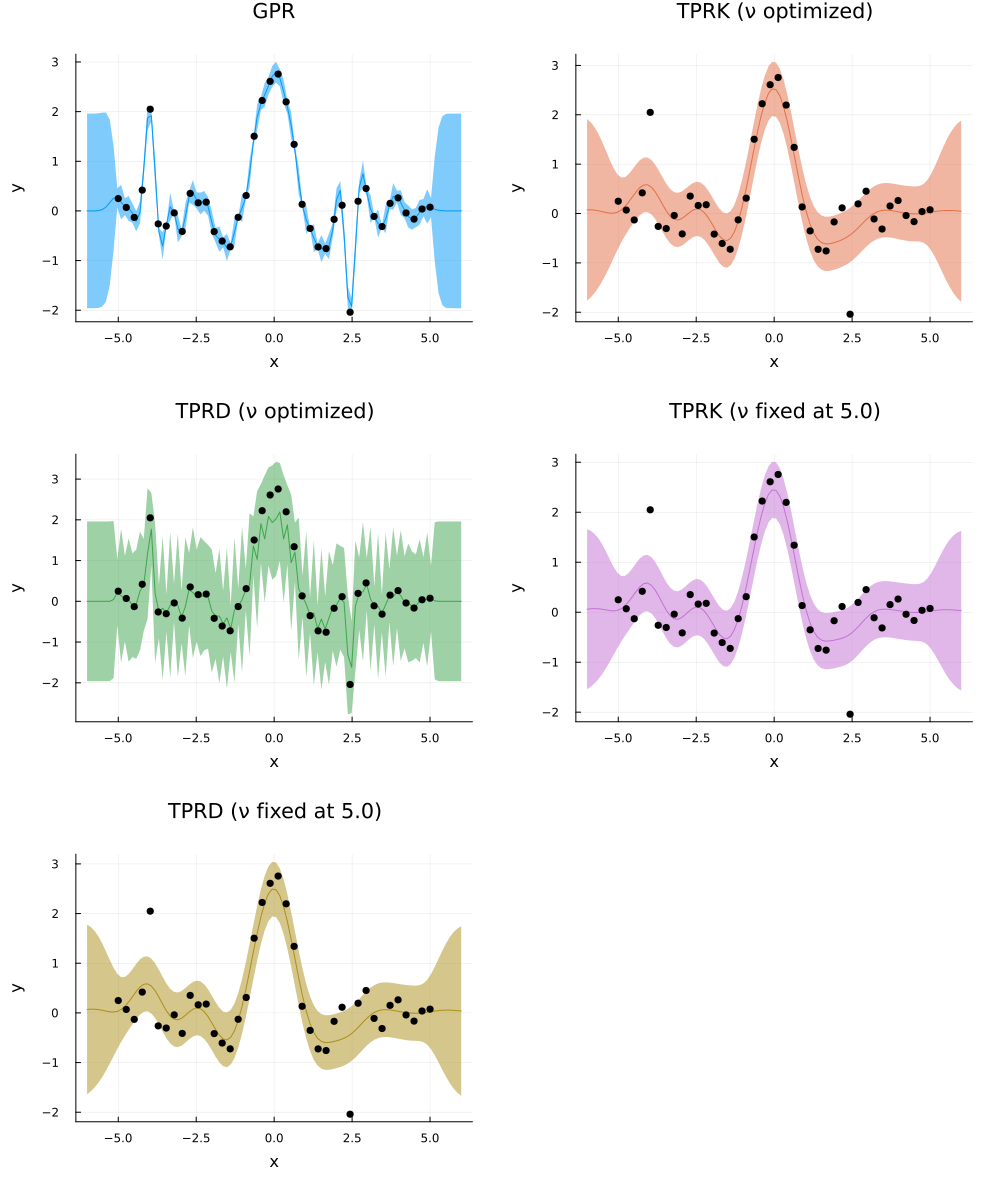

In [2]:
# --- メイン関数（実行例） ---
function main()
    println("--- GPR vs TPRK vs TPRD 比較実行例 ---")

    n_train = 40
    X_train = reshape(collect(range(-5, 5, length=n_train)), 1, n_train)
    y_train = sinc.(X_train[1,:]) .* 3.0 + rand(Normal(0, 0.2), n_train)
    y_train[5] += 2.0; y_train[30] -= 2.5

    # --- モデルの初期化 ---
    gpr = GaussianProcess(X_train, y_train, init_params_θ=[log(1.0), log(0.1)])
    tprk = StudentTProcess(X_train, y_train, :TPRK, init_params_θ=[log(1.0), log(0.1)], init_ν=5.0)
    tprd = StudentTProcess(X_train, y_train, :TPRD, init_params_θ=[log(1.0), log(0.1)], init_ν=5.0)
    # νを5に固定したモデル
    tprk_fixed_nu = StudentTProcess(X_train, y_train, :TPRK, init_params_θ=[log(1.0), log(0.1)], init_ν=5.0)
    tprd_fixed_nu = StudentTProcess(X_train, y_train, :TPRD, init_params_θ=[log(1.0), log(0.1)], init_ν=5.0)


    # --- モデルの学習 ---
    println("\n--- GPRの学習開始 ---"); fit!(gpr, max_iters=200)
    println("\n--- TPRKの学習開始 (全ハイパラ) ---"); fit!(tprk, max_iters=200)
    println("\n--- TPRDの学習開始 (全ハイパラ) ---"); fit!(tprd, max_iters=200)
    println("\n--- TPRKの学習開始 (ν=5.0 に固定) ---"); fit!(tprk_fixed_nu, fixed_params=Dict(:nu => 5.0), max_iters=200)
    println("\n--- TPRDの学習開始 (ν=5.0 に固定) ---"); fit!(tprd_fixed_nu, fixed_params=Dict(:nu => 5.0), max_iters=200)


    # --- 予測 ---
    n_test = 100
    X_test = reshape(collect(range(-6, 6, length=n_test)), 1, n_test)
    μ_gpr, σ_gpr = predict(gpr, X_test)
    μ_tprk, σ_tprk = predict(tprk, X_test)
    μ_tprd, σ_tprd = predict(tprd, X_test)
    μ_tprk_fixed, σ_tprk_fixed = predict(tprk_fixed_nu, X_test)
    μ_tprd_fixed, σ_tprd_fixed = predict(tprd_fixed_nu, X_test)


    # --- 結果のプロット ---
    # 5つのプロットを表示するためにレイアウトを変更
    p = plot(layout=(3, 2), size=(1000, 1200), legend=false, margin=5Plots.mm)

    # GPRのプロット
    plot!(p[1], title="GPR", xlabel="x", ylabel="y");
    plot!(p[1], X_test[1,:], μ_gpr, ribbon=1.96σ_gpr, c=1, label="Prediction");
    scatter!(p[1], X_train[1,:], y_train, c=:black, label="Data")

    # TPRK (ν最適化) のプロット
    plot!(p[2], title="TPRK (ν optimized)", xlabel="x", ylabel="y");
    plot!(p[2], X_test[1,:], μ_tprk, ribbon=1.96σ_tprk, c=2, label="Prediction");
    scatter!(p[2], X_train[1,:], y_train, c=:black, label="Data")

    # TPRD (ν最適化) のプロット
    plot!(p[3], title="TPRD (ν optimized)", xlabel="x", ylabel="y");
    plot!(p[3], X_test[1,:], μ_tprd, ribbon=1.96σ_tprd, c=3, label="Prediction");
    scatter!(p[3], X_train[1,:], y_train, c=:black, label="Data")

    # TPRK (ν固定) のプロット
    plot!(p[4], title="TPRK (ν fixed at 5.0)", xlabel="x", ylabel="y");
    plot!(p[4], X_test[1,:], μ_tprk_fixed, ribbon=1.96σ_tprk_fixed, c=4, label="Prediction");
    scatter!(p[4], X_train[1,:], y_train, c=:black, label="Data")

    # TPRD (ν固定) のプロット
    plot!(p[5], title="TPRD (ν fixed at 5.0)", xlabel="x", ylabel="y");
    plot!(p[5], X_test[1,:], μ_tprd_fixed, ribbon=1.96σ_tprd_fixed, c=5, label="Prediction");
    scatter!(p[5], X_train[1,:], y_train, c=:black, label="Data")
    
    # 未使用のプロットを非表示に
    plot!(p[6], showaxis=false, grid=false)
    
    display(p)
    
    println("\n--- 最適化されたハイパーパラメータ ---")
    println("GPR             - log(l): $(round(gpr.params_θ[1], digits=4)), log(σ_n): $(round(gpr.params_θ[2], digits=4))")
    println("TPRK (optim)    - log(l): $(round(tprk.params_θ[1], digits=4)), log(σ_n): $(round(tprk.params_θ[2], digits=4)), ν: $(round(get_ν(tprk), digits=4))")
    println("TPRD (optim)    - log(l): $(round(tprd.params_θ[1], digits=4)), log(σ_n): $(round(tprd.params_θ[2], digits=4)), ν: $(round(get_ν(tprd), digits=4))")
    println("TPRK (fixed ν)  - log(l): $(round(tprk_fixed_nu.params_θ[1], digits=4)), log(σ_n): $(round(tprk_fixed_nu.params_θ[2], digits=4)), ν: $(round(get_ν(tprk_fixed_nu), digits=4))")
    println("TPRD (fixed ν)  - log(l): $(round(tprd_fixed_nu.params_θ[1], digits=4)), log(σ_n): $(round(tprd_fixed_nu.params_θ[2], digits=4)), ν: $(round(get_ν(tprd_fixed_nu), digits=4))")
end

main()

In [ ]:
 Function value   Gradient norm 
     0     4.974459e+02     2.798749e+00
 * time: 2.6941299438476562e-5
     1     4.963030e+02     2.223602e+00
 * time: 0.04249215126037598
     2     4.298717e+02     5.834177e+01
 * time: 0.2388319969177246
     3     4.278462e+02     3.166221e+01
 * time: 0.394118070602417
     4     3.593790e+02     8.979627e+01
 * time: 0.4902310371398926
     5     3.567253e+02     8.392435e+01
 * time: 0.5194849967956543
     6     3.126131e+02     4.425472e+01
 * time: 0.5606529712677002
     7     2.804407e+02     1.593913e+00
 * time: 0.5869319438934326
     8     2.803206e+02     1.129391e+01
 * time: 0.6149210929870605
     9     2.798731e+02     2.06872

In [5]:
using CSV, DataFrames

function load_and_standardize_data(dataset_name::String, split_idx::Int)
    base_path = joinpath("datasets", dataset_name, "split_$(split_idx)")
    
    # データの読み込み
    df_X_train = CSV.read(joinpath(base_path, "train_features.csv"), DataFrame, header=false)
    df_y_train = CSV.read(joinpath(base_path, "train_target.csv"), DataFrame, header=false)
    df_X_test = CSV.read(joinpath(base_path, "test_features.csv"), DataFrame, header=false)
    df_y_test = CSV.read(joinpath(base_path, "test_target.csv"), DataFrame, header=false)

    # Matrix/Vectorに変換
    X_train = Matrix(df_X_train)' # 特徴量次元 x サンプル数 の形式に転置
    y_train = vec(Matrix(df_y_train))
    X_test = Matrix(df_X_test)'
    y_test = vec(Matrix(df_y_test))

    return X_train, y_train, X_test, y_test
end

X_train, y_train, X_test, y_test = load_and_standardize_data("Bike", 1)


([1.0 2.0 … 360.0 362.0; 1.0 1.0 … 1.0 1.0; … ; 13.0 32.0 … 70.0 95.0; 16.0 40.0 … 93.0 118.0], [16.0, 40.0, 32.0, 13.0, 1.0, 2.0, 3.0, 14.0, 36.0, 56.0  …  23.0, 16.0, 1.0, 1.0, 3.0, 18.0, 32.0, 79.0, 93.0, 118.0], [6.0 9.0 … 759.0 765.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 7.0 … 10.0 87.0; 1.0 8.0 … 13.0 87.0], [1.0, 8.0, 106.0, 6.0, 1.0, 8.0, 53.0, 93.0, 53.0, 88.0  …  112.0, 68.0, 156.0, 8.0, 168.0, 63.0, 78.0, 175.0, 13.0, 87.0])

In [6]:
size(X_train), size(y_train), size(X_test), size(y_test)

((16, 320), (320,), (16, 80), (80,))

In [ ]:
# ==========================================================================
#
#   モデルのパフォーマンス計測用コード
#   (GPR, TPRK, TPRD, TPRK-fixed-nu, TPRD-fixed-nu)
#
# ==========================================================================

using CSV
using DataFrames
using Statistics
using Printf

# (ここに前回までのモデル定義コード: SquaredExponentialKernel, GaussianProcess, 
#  StudentTProcess, および関連する関数 fit!, predict, log_marginal_likelihood など
#  がすべて含まれていると仮定します)

# --- データセットの読み込みと標準化のためのヘルパー関数 ---

"""
データを読み込み、標準化する関数
"""
function load_and_standardize_data(dataset_name::String, split_idx::Int)
    base_path = joinpath("datasets", dataset_name, "split_$(split_idx)")
    
    # データの読み込み
    df_X_train = CSV.read(joinpath(base_path, "train_features.csv"), DataFrame, header=false)
    df_y_train = CSV.read(joinpath(base_path, "train_target.csv"), DataFrame, header=false)
    df_X_test = CSV.read(joinpath(base_path, "test_features.csv"), DataFrame, header=false)
    df_y_test = CSV.read(joinpath(base_path, "test_target.csv"), DataFrame, header=false)

    # Matrix/Vectorに変換
    X_train = Matrix(df_X_train)' # 特徴量次元 x サンプル数 の形式に転置
    y_train = vec(Matrix(df_y_train))
    X_test = Matrix(df_X_test)'
    y_test = vec(Matrix(df_y_test))

    # 特徴量の標準化
    μ_X = mean(X_train, dims=2)
    σ_X = std(X_train, dims=2)
    σ_X[σ_X .== 0] .= 1.0 # 分散が0の場合のゼロ除算を回避
    X_train_std = (X_train .- μ_X) ./ σ_X
    X_test_std = (X_test .- μ_X) ./ σ_X
    
    # ターゲットの標準化
    μ_y = mean(y_train)
    σ_y = std(y_train)
    y_train_std = (y_train .- μ_y) ./ σ_y
    
    return (X_train_std, y_train_std, X_test_std, y_test), (μ_y, σ_y)
end

"""
RMSEを計算する関数
"""
function rmse(y_true, y_pred)
    return sqrt(mean((y_true .- y_pred).^2))
end

# --- メインの評価関数 ---

function evaluate_models()
    # treeコマンドで表示されたデータセットのリスト
    dataset_names = ["Bike", "Concrete", "Diabetes", "ELE", "Machine CPU", "MPG", "Neal", "Neal_XOutlier"]
    
    println("="^60)
    println("モデルパフォーマンス評価を開始します。")
    println("="^60)

    # 各データセットに対して評価を実行
    for dataset_name in dataset_names
        println("\n--- データセット: $(dataset_name) の評価 ---")
        
        # 10回の分割に対するRMSEを格納する辞書
        results = Dict(
            :GPR => Float64[], 
            :TPRK => Float64[], 
            :TPRD => Float64[],
            :TPRK_fixed_nu => Float64[],
            :TPRD_fixed_nu => Float64[]
        )
        
        # 評価するモデルの設定リスト
        model_configs = [
            (name=:GPR,           model_type=:GPR,  fixed_params=Dict()),
            (name=:TPRK,          model_type=:TPRK, fixed_params=Dict()),
            (name=:TPRD,          model_type=:TPRD, fixed_params=Dict()),
            (name=:TPRK_fixed_nu, model_type=:TPRK, fixed_params=Dict(:nu => 5.0)),
            (name=:TPRD_fixed_nu, model_type=:TPRD, fixed_params=Dict(:nu => 5.0))
        ]

        for i in 0:9
            println("  Split $(i)/9 を処理中...")
            try
                # データの読み込みと標準化
                (X_train, y_train, X_test, y_test), (μ_y, σ_y) = load_and_standardize_data(dataset_name, i)

                for config in model_configs
                    # モデルの初期化
                    if config.model_type == :GPR
                        model = GaussianProcess(X_train, y_train, init_params_θ=[0.0, log(0.1)])
                    else
                        model = StudentTProcess(X_train, y_train, config.model_type, init_params_θ=[0.0, log(0.1)], init_ν=5.0)
                    end
                    
                    # 学習
                    fit!(model, fixed_params=config.fixed_params, max_iters=200)
                    
                    # 予測
                    μ_pred_std, _ = predict(model, X_test)
                    
                    # スケールを元に戻す
                    μ_pred = μ_pred_std .* σ_y .+ μ_y
                    
                    # RMSEの計算と保存
                    error = rmse(y_test, μ_pred)
                    push!(results[config.name], error)
                end
            catch e
                println("    エラー発生: Split $(i) の処理をスキップします。エラー: ", e)
                # エラーが発生した場合はNaNを結果に追加
                for config in model_configs
                    push!(results[config.name], NaN)
                end
            end
        end

        # 結果の集計と表示
        println("\n[結果] データセット: $(dataset_name)")
        println("-"^55)
        @printf("%-18s | %-18s | %-18s\n", "モデル", "平均RMSE", "RMSE標準偏差")
        println("-"^55)
        for config in model_configs
            name = config.name
            valid_rmses = filter(!isnan, results[name])
            if isempty(valid_rmses)
                mean_err, std_err = NaN, NaN
            else
                mean_err = mean(valid_rmses)
                std_err = std(valid_rmses)
            end
            @printf("%-18s | %-18.4f | %-18.4f\n", string(name), mean_err, std_err)
        end
        println("-"^55)
    end
    
    println("\n" * "="^60)
    println("全ての評価が完了しました。")
    println("="^60)
end

# 評価関数を実行
evaluate_models()

モデルパフォーマンス評価を開始します。

--- データセット: Bike の評価 ---
  Split 0/9 を処理中...
Iter     Function value   Gradient norm 
     0     2.632440e+02     2.904253e+02
 * time: 4.410743713378906e-5
     1    -3.525953e+01     8.544869e+02
 * time: 0.037360191345214844
     2    -3.816426e+02     2.259274e+02
 * time: 0.04566502571105957
     3    -9.575069e+02     2.465531e+02
 * time: 0.06157207489013672
     4    -1.132716e+03     4.369283e+02
 * time: 0.06987619400024414
     5    -1.232457e+03     2.031211e+01
 * time: 0.07813119888305664
     6    -1.257787e+03     4.174989e+01
 * time: 0.10253715515136719
     7    -1.258571e+03     6.920484e+00
 * time: 0.12310218811035156
     8    -1.258590e+03     2.858425e-02
 * time: 0.1314070224761963
     9    -1.258590e+03     5.692798e-02
 * time: 0.14761114120483398
    10    -1.258596e+03     1.472378e+00
 * time: 0.17966914176940918
    11    -1.258597e+03     5.277690e-02
 * time: 0.19192004203796387
    12    -1.258597e+03     5.186622e-01
 * time: 0.